In [1]:
import os
import pyspark
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
KEYSPACE = "sparkassandra"
APP_NAME = KEYSPACE
CASSANDRA_IP = "cassandra_node"

## Init PySpark

In [3]:
SUBMIT_ARGS = "--packages com.databricks:spark-csv_2.10:1.2.0,com.datastax.spark:spark-cassandra-connector_2.10:1.6.0-M1 pyspark-shell"

os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

In [4]:
# Make sure the driver and workers all use Python2
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python'

In [5]:
#Init Spark Conf
conf = pyspark.SparkConf().setAppName(APP_NAME)
conf.set("spark.cassandra.connection.host",CASSANDRA_IP)
conf.set("spark.executor.memory", "8g")

In [6]:
# Init Spark Context
sc = pyspark.SparkContext('spark://10.0.0.2:7077', conf = conf)

In [7]:
# Init Spark SQL Context
sql_ctx = SQLContext(sc)

## Load Flight Data from Cassandra (us_flights table)

In [81]:
flights_df = sql_ctx.read.format("org.apache.spark.sql.cassandra").options(table="us_flights", keyspace=KEYSPACE).load()
flights_df = flights_df.dropna()

In [82]:
flights_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- actualelapsedtime: string (nullable = true)
 |-- airtime: string (nullable = true)
 |-- arrdelay: string (nullable = true)
 |-- arrtime: string (nullable = true)
 |-- cancellationcode: string (nullable = true)
 |-- cancelled: string (nullable = true)
 |-- carrierdelay: string (nullable = true)
 |-- crsarrtime: string (nullable = true)
 |-- crsdeptime: string (nullable = true)
 |-- crselapsedtime: string (nullable = true)
 |-- dayofmonth: string (nullable = true)
 |-- dayofweek: string (nullable = true)
 |-- depdelay: string (nullable = true)
 |-- deptime: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- diverted: string (nullable = true)
 |-- flightnum: string (nullable = true)
 |-- lateaircraftdelay: string (nullable = true)
 |-- month: string (nullable = true)
 |-- nasdelay: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- securitydelay: string (nullable = true)
 |-

In [83]:
def convertColumn(df, name, newType) :
    df_1 = df.withColumnRenamed(name, "swap")
    df_1 = df_1.withColumn(name, df_1["swap"].cast(newType)).drop("swap")
    return df_1

In [84]:
flights_df = convertColumn(flights_df, "dayofweek", "int")
flights_df = convertColumn(flights_df, "arrdelay", "int")
flights_df = convertColumn(flights_df, "depdelay", "int")

In [85]:
flights_df.registerTempTable("flight")

## When is the best day of week to fly to minimise delays?

In [14]:
# SQL Request method
#sql_ctx.sql("""SELECT DayOfWeek as weekday, avg(ArrDelay) as avg_delay 
#                                FROM flight
#                                GROUP BY DayOfWeek
#                                ORDER BY avg_delay DESC""").show()

In [87]:
# DataFrame syntax
df_minimise_delays_weekday = (flights_df
                              .select('dayofweek', 'arrdelay')
                              .groupBy('dayofweek')
                              .agg(F.avg('arrdelay').alias('AVG_DELAY_ARR')))
df_minimise_delays_weekday.show()

+---------+-----------------+
|dayofweek|    AVG_DELAY_ARR|
+---------+-----------------+
|        1|6.499125293976524|
|        2|7.186731919022949|
|        3|8.577337262836334|
|        4|9.614141357287465|
|        5|9.670663099579311|
|        6|5.014933378313935|
|        7|6.154075524251174|
+---------+-----------------+



In [89]:
df_minimise_delays_weekday_pd = df_minimise_delays_weekday.toPandas()
df_minimise_delays_weekday_pd

,dayofweek,AVG_DELAY_ARR
0,1,6.499125
1,2,7.186732
2,3,8.577337
3,4,9.614141
4,5,9.670663
5,6,5.014933
6,7,6.154076


In [90]:
def convert_day_of_week(val):
    week   = ['Monday', 
              'Tuesday', 
              'Wednesday', 
              'Thursday',  
              'Friday', 
              'Saturday',
              'Sunday']

    return week[int(val)-1]

In [91]:
df_minimise_delays_weekday_pd["DAY_OF_WEEK"] = df_minimise_delays_weekday_pd.dayofweek.apply(convert_day_of_week)

In [92]:
df_minimise_delays_weekday_pd[["DAY_OF_WEEK","AVG_DELAY_ARR"]]

,DAY_OF_WEEK,AVG_DELAY_ARR
0,Monday,6.499125
1,Tuesday,7.186732
2,Wednesday,8.577337
3,Thursday,9.614141
4,Friday,9.670663
5,Saturday,5.014933
6,Sunday,6.154076


<function matplotlib.pyplot.legend>

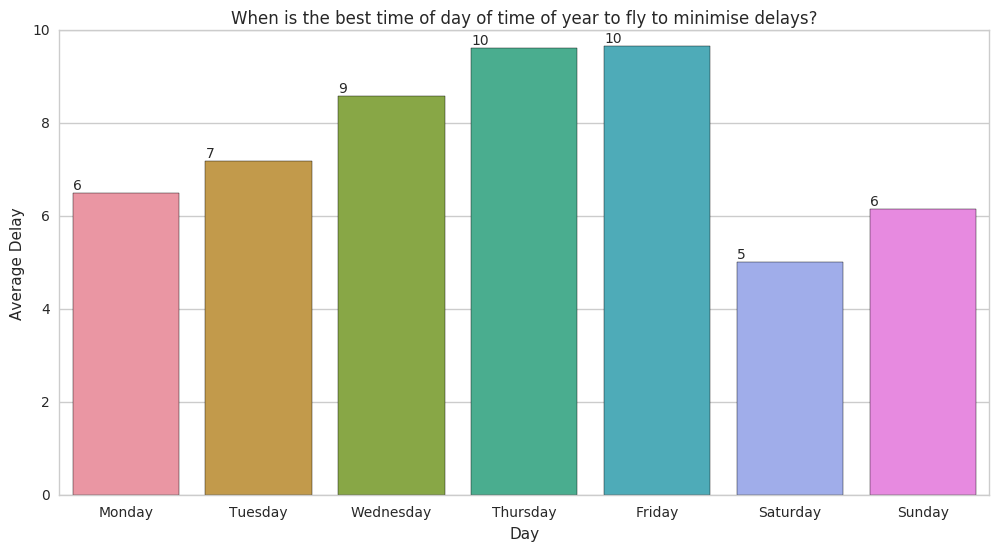

In [128]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,6))
ax = sns.barplot(x='DAY_OF_WEEK', y='AVG_DELAY_ARR', data=df_minimise_delays_weekday_pd)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x(), height+ 0.08, '%1.00f'%p.get_height())
plt.title('When is the best time of day of time of year to fly to minimise delays?')
plt.xlabel('Day')
plt.ylabel('Average Delay')
plt.legend

## When is the best day of week of month to fly to minimise delays?

In [94]:
df_minimise_delays_weekday_month = (flights_df
                               .select('month', 'dayofweek', 'arrdelay')
                               .groupBy('dayofweek').pivot('month').avg('arrdelay'))

df_minimise_delays_weekday_month.show()

+---------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+
|dayofweek|                 1|               10|                11|                12|                 2|                 3|                 4|                 5|                6|                 7|                8|                 9|
+---------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+
|        1|  8.95674767749939|4.151780026370761|5.8028160205841095|10.365620772024315|6.2598016572033535|11.223011524655204| 4.606463004744769|1.8298407555053402|6.822792691821886| 5.209551245332876|7.910395191779494| 2.940413341518314|
|        2| 8.511072418803383|5.364624865915117| 8.5

In [119]:
# Convert to Pandas
pd_minimise_delays_weekday_month = df_minimise_delays_weekday_month.toPandas()
pd_minimise_delays_weekday_month

,dayofweek,1,10,11,12,2,3,4,5,6,7,8,9
0,1,8.956748,4.151780,5.802816,10.365621,6.259802,11.223012,4.606463,1.829841,6.822793,5.209551,7.910395,2.940413
1,2,8.511072,5.364625,8.585522,13.803709,7.132561,12.989775,4.628633,3.007719,6.199235,5.905245,6.883559,2.930615
2,3,11.255739,6.094104,8.022868,15.131858,8.449787,7.824802,4.483683,4.435327,8.749658,7.576737,7.528000,4.672490
3,4,12.283326,8.018694,6.755673,14.160278,10.288258,10.820912,6.926488,6.191600,8.885840,8.124901,7.799819,6.887641
4,5,11.725659,7.780286,6.337611,12.673281,11.774841,14.161078,5.437996,6.766486,8.978869,7.139285,8.581971,9.326092
5,6,6.558712,2.585700,4.342053,9.946786,5.793103,9.462827,3.291819,0.974051,4.052585,4.419748,5.366258,1.885540
6,7,8.443807,4.694224,8.102383,8.415578,5.377355,7.802946,4.703195,2.467031,4.137947,6.129150,6.301491,1.722150


In [120]:
# Add Month column name to index columns
pd_minimise_delays_weekday_month.columns.names = ['Month']

# Add Day of week
pd_minimise_delays_weekday_month["DAY_OF_WEEK"] = pd_minimise_delays_weekday_month.dayofweek.apply(convert_day_of_week)

# Update index values by DAY_OF_WEEK values & drop DAY_OF_WEEK columns
pd_minimise_delays_weekday_month = pd_minimise_delays_weekday_month.rename(index=pd_minimise_delays_weekday_month.DAY_OF_WEEK)

pd_minimise_delays_weekday_month = pd_minimise_delays_weekday_month.drop('dayofweek', axis=1)
pd_minimise_delays_weekday_month = pd_minimise_delays_weekday_month.drop('DAY_OF_WEEK', axis=1)

pd_minimise_delays_weekday_month.rename(columns={'1': 'January', '2': 'February', '3': 'March','4': 'April','5': 'May', '6': 'June','7': 'July','8': 'August','9': 'September','10': 'October', '11': 'November','12': 'December'}, inplace=True)

pd_minimise_delays_weekday_month = pd_minimise_delays_weekday_month.reindex_axis(["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], axis=1)
pd_minimise_delays_weekday_month

Month,January,February,March,April,May,June,July,August,September,October,November,December
Monday,8.956748,6.259802,11.223012,4.606463,1.829841,6.822793,5.209551,7.910395,2.940413,4.151780,5.802816,10.365621
Tuesday,8.511072,7.132561,12.989775,4.628633,3.007719,6.199235,5.905245,6.883559,2.930615,5.364625,8.585522,13.803709
Wednesday,11.255739,8.449787,7.824802,4.483683,4.435327,8.749658,7.576737,7.528000,4.672490,6.094104,8.022868,15.131858
Thursday,12.283326,10.288258,10.820912,6.926488,6.191600,8.885840,8.124901,7.799819,6.887641,8.018694,6.755673,14.160278
Friday,11.725659,11.774841,14.161078,5.437996,6.766486,8.978869,7.139285,8.581971,9.326092,7.780286,6.337611,12.673281
Saturday,6.558712,5.793103,9.462827,3.291819,0.974051,4.052585,4.419748,5.366258,1.885540,2.585700,4.342053,9.946786
Sunday,8.443807,5.377355,7.802946,4.703195,2.467031,4.137947,6.129150,6.301491,1.722150,4.694224,8.102383,8.415578


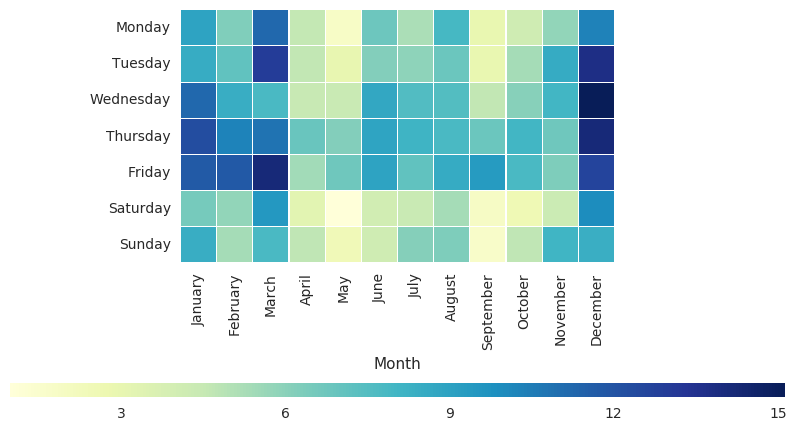

In [121]:
# Draw a heatmap 
grid_kws = {"height_ratios": (.9, .05), "hspace": 0.9}
f, (ax, cbar_ax) = plt.subplots(2, figsize=(10, 5),gridspec_kw=grid_kws)
sns.heatmap(pd_minimise_delays_weekday_month, ax=ax, linewidths=0.01, cmap="YlGnBu", square=True, cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"})

## Load Airports Data

In [129]:
airports_df = sql_ctx.read.format("org.apache.spark.sql.cassandra").options(table="airports", keyspace=KEYSPACE).load()

In [130]:
airports_df.printSchema()

root
 |-- iata: string (nullable = true)
 |-- airport: string (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- state: string (nullable = true)



## When is the best airport to fly to minimise delays?

In [131]:
df_minimise_delays_airport_dest = (flights_df
                              .select('dest', 'arrdelay')
                              .groupBy('dest')
                              .agg(F.avg('arrdelay').alias('AVG_DELAY_ARR'))
                              .sort(F.desc('AVG_DELAY_ARR')))

In [132]:
# merge with airport data

df_minimise_delays_airport_dest = (df_minimise_delays_airport_dest
                 .join(airports_df, df_minimise_delays_airport_dest.dest == airports_df.iata, 'inner'))
df_minimise_delays_airport_dest.show(4)

+----+------------------+----+--------------------+-------+-------+-----------+------------+-----+
|dest|     AVG_DELAY_ARR|iata|             airport|   city|country|        lat|        long|state|
+----+------------------+----+--------------------+-------+-------+-----------+------------+-----+
| IAH| 7.286961154408183| IAH|George Bush Inter...|Houston|    USA|29.98047222|-95.33972222|   TX|
| GEG| 8.515734406438632| GEG|        Spokane Intl|Spokane|    USA|47.61985556|-117.5338425|   WA|
| YUM|3.0964797913950455| YUM|Yuma MCAS-Yuma In...|   Yuma|    USA|32.65658333|-114.6059722|   AZ|
| TUS|7.8774270690381405| TUS|Tucson International| Tucson|    USA|32.11608333|-110.9410278|   AZ|
+----+------------------+----+--------------------+-------+-------+-----------+------------+-----+
only showing top 4 rows



In [133]:
pd_minimise_delays_airport_dest = df_minimise_delays_airport_dest.toPandas()

In [134]:
pd_minimise_delays_airport_dest.to_csv("pd_minimise_delays_airport_dest.csv", sep=";")